## This file contains the GCML implementation for an abstract graph with rewards.

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader  
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.rcParams['figure.dpi'] = 300  

def init_random_seed(seed=123456):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果有多个GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    
init_random_seed(seed=123456)

In [2]:
dir_name = "tmp_data"

if not os.path.exists(dir_name):
    os.makedirs(dir_name) 

In [3]:
# function to generate a random graph
def construct_random_subgraph(num_nodes, min_edges=2, max_edges=5):
    min_edges-=1
    max_edges-=1
    connections = np.random.uniform(size=(num_nodes, num_nodes))
    connections += np.roll(np.eye(num_nodes), 1, 1)  # make sure every node is connected
    connections -= np.eye(num_nodes)  # make sure no self-connections
    # set strongest connections
    sorted_connections = np.sort(connections)[:, ::-1]
    min_edges = min_edges
    max_edges = max_edges + 1
    min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
    max_edges = int(max_edges / 2 + 0.5)
    indices = np.stack([np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)])
    thresholds = sorted_connections[indices[0], indices[1]]
    connections = np.where(connections > thresholds[:, None], 1., 0.).astype(np.float32)
    connections = np.clip(connections + connections.T, 0, 1)
    return connections

# function to generate a random small world graph
def construct_small_world_graph(n_nodes_per_world=6, n_worlds=4):
    n_nodes = n_nodes_per_world * n_worlds
    connections = np.zeros((n_nodes, n_nodes))
    for world_i in range(n_worlds):
        connection = construct_random_subgraph(n_nodes_per_world)
        # add to global graph
        start_i = world_i * n_nodes_per_world
        end_i = (world_i+1) * n_nodes_per_world
        connections[start_i:end_i, start_i:end_i] = connection
        # connect to graph
        if world_i != 0:
            node_from = np.random.randint(start_i, end_i)
            node_to = node_from - n_nodes_per_world
            connections[node_from, node_to] = 1
            connections[node_to, node_from] = 1
    return connections

# function to generate a dead ends graph
def construct_dead_ends_graph():
    # construct the shell-like connectivity
    n_shells = 4
    n_neurons_per_shell = 6
    layers_with_circular_connection = [1]
    size = n_shells * n_neurons_per_shell
    connections = np.zeros((size, size)).astype(np.float32)
    eye = np.eye(n_neurons_per_shell)
    for i in range(n_shells):
        if i in layers_with_circular_connection:
            # add circular connection
            idx = i * n_neurons_per_shell
            connections[idx:idx+n_neurons_per_shell, idx:idx+n_neurons_per_shell] = np.roll(eye, 1, axis=1)

        # add connections to next shell
        if i + 1 < n_shells:
            # connect to outer shell
            idx = i * n_neurons_per_shell
            j = idx + n_neurons_per_shell
            connections[idx:idx+n_neurons_per_shell, j:j+n_neurons_per_shell] = eye

    connections = connections + connections.T
    return connections

# function to generate a grid graph with numerical paths to move to a target
def construct_grid_graph():
    n = 4
    l = 5
    n_nodes = n * l + l // 2

    tmp_n_nodes = 0
    layer_index_bounds = []
    for i in range(l):
        tmp_n_nodes += n if i % 2 == 0 else n + 1
        layer_index_bounds.append(tmp_n_nodes)

    connections = []

    lower_idx = 0
    for layer_idx in range(l):
        upper_idx = layer_index_bounds[layer_idx]
        for i in range(lower_idx, upper_idx):
            if i + 1 < upper_idx:
                connections.append([i, i + 1])
            if layer_idx + 1 < l:
                # not last layer
                next_upper_idx = layer_index_bounds[layer_idx+1]
                dist1 = n if layer_idx % 2 == 0 else n + 1
                dist2 = n + 1 if layer_idx % 2 == 0 else n
                if upper_idx <= i + dist1 < next_upper_idx:
                    connections.append([i, i + dist1])
                if upper_idx <= i + dist2 < next_upper_idx:
                    connections.append([i, i + dist2])
        lower_idx = upper_idx
    connections = np.array(connections)
    i, j = connections.T
    adj = np.zeros((n_nodes, n_nodes))
    adj[i, j] = 1
    adj += adj.T
    return adj

In [4]:
# Create a dataset of trajectories
class RandomWalkDataset(Dataset):
    def __init__(self, adj_matrix, trajectory_length, num_trajectories):
        self.adj_matrix = adj_matrix
        self.num_trajectories = num_trajectories
        self.trajectory_length = trajectory_length
        self.edges, self.action_indices = edges_from_adjacency(adj_matrix)
        start_nodes = torch.randint(0, adj_matrix.size(0), (num_trajectories,)).tolist()
        self.data = []
        for node in start_nodes:
            trajectory = strict_random_walk(self.adj_matrix, node, self.trajectory_length, self.action_indices)
            self.data.append(torch.tensor([(x[0], x[1], x[2]) for x in trajectory]))
    
    def __len__(self):
        return self.num_trajectories  # Number of trajectories

    def __getitem__(self, idx):
        return self.data[idx]
    
    
# function to generate random walk trajectories on a given graph
def strict_random_walk(adj_matrix, start_node, length, action_indices):
    current_node = start_node
    trajectory = []
    for _ in range(length - 1):  # subtract 1 to account for the start node
        neighbors = torch.where(adj_matrix[current_node] > 0)[0].tolist()
        if not neighbors:
            break
        next_node = neighbors[torch.randint(0, len(neighbors), (1,)).item()]
        trajectory.append((current_node, action_indices[(current_node, next_node)], next_node))
        current_node = next_node
    return trajectory

# indexing each action for a given adjacency matrix
def edges_from_adjacency(adj_matrix):
    # The input is a given random matrix's adjacency matrix
    # The outputs are:
        # edges: a list of pairs of (start node, end node) for each action
        # action_indices: a dictionary, each key is a pair of(start node, end node),
            # and its corresponding value is this action's index
    # For a pure on-line algorithm, this can also be done by assigning index to unseen actions
    # during random-walk on-line
    n = adj_matrix.shape[0]
    edges = []
    action_idx = 0
    action_indices = {}
    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle
            if adj_matrix[i][j] != 0:
                edges.append((i, j))
                action_indices[(i, j)] = action_idx
                action_idx += 1
                edges.append((j, i))
                action_indices[(j, i)] = action_idx
                action_idx += 1
    return edges, action_indices

In [5]:
class GraphEnv():
    def __init__(self, size=32, env='random', env_config={}):
        if env == 'random':
            self.adj_matrix = construct_random_subgraph(size, 2, 6)
        elif env == 'small world':
            self.adj_matrix = construct_small_world_graph()
        elif env == 'dead ends':
            self.adj_matrix = construct_dead_ends_graph()
        elif env == 'grid':
            self.adj_matrix = construct_grid_graph()

        # Choose one from the following options
        # option 1: random generated abstract graph
        # self.adj_matrix = torch.tensor(self.adj_matrix)

        # option 2: the abstract graph used in the paper
        self.adj_matrix = torch.tensor(
            [[0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
            [0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
            [1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],  #
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0]])
        
        self.size = self.adj_matrix.shape[0]
        self.affordance, self.node_to_action_matrix, self.action_to_node = node_outgoing_actions(self.adj_matrix)
        
        self.affordance = {k: torch.tensor(v).to(device) for k, v in self.affordance.items()}
        self.node_to_action_matrix = self.node_to_action_matrix.to(device)
        self.action_to_node = {k: torch.tensor(v).to(device) for k, v in self.action_to_node.items()}
        
        self.dataset = RandomWalkDataset(self.adj_matrix, env_config["batch_size"], env_config["num_desired_trajectories"])
        self.n_actions = len(self.dataset.action_indices)

        self.reward = torch.rand((self.adj_matrix.shape[0]), device=device, dtype=torch.float32) * 10
    
    def print_info(self):
        print("adj_matrix:", self.adj_matrix)
        print("size:", self.size)
        print("affordance:", self.affordance)
        print("node_to_action_matrix:", self.node_to_action_matrix)
        print("action_to_node:", self.action_to_node)
        print("n_actions:", self.n_actions)
        
def node_outgoing_actions(adj_matrix):
    # This function creates several look-up tables for later computation's convecience
    edges, action_indices = edges_from_adjacency(adj_matrix)
    # Use an action index as a key, retrieve its (start node, end node)
    inverse_action_indices = {v: k for k, v in action_indices.items()}
    # Given a node as a key, retrieve all of its available outgoing actions' indexes.
    node_actions = {}
    # Given a pair of (start node, end node), get the action index.
    # Since a index can be 0, this matrix is initialized to be a all -1.
    node_to_action_matrix = -1*torch.ones_like(adj_matrix)
    for edge in edges:
        node_from, node_to = edge
        if node_from not in node_actions:
            node_actions[node_from] = []
        node_actions[node_from].append(action_indices[edge])
        node_to_action_matrix[node_from][node_to] = action_indices[edge]  
    return node_actions, node_to_action_matrix.long(), inverse_action_indices

w_connection = []

In [6]:
def run_t_sne(model, env, perp=12, early_exaggeration=3, learning_rate=20, start=None, goal=None, label=False, name=""):
    data = model.Q.data.T.cpu().numpy().astype(float)
    
    N_nodes = env.adj_matrix.cpu().shape[0]
    tsne = TSNE(2, perplexity=perp, init='pca',
                early_exaggeration=early_exaggeration, learning_rate=learning_rate)
    data_2d = tsne.fit_transform(data)

    adjacency = env.adj_matrix.cpu().numpy()
    if start == goal == None:
        G = nx.from_numpy_array(adjacency, create_using=nx.Graph())
    pos = {}
    for i in range(N_nodes):
        pos[i] = data_2d[i]

    if start!= None and goal!=None:
        fig, ax = plt.subplots(figsize=(10,8.5),dpi=300)
        G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph())
        edge_colors = []
        do_not_show = []
        with torch.no_grad():
            delta = model.Q[:,goal] - model.Q[:,start]
            utility = model.W@delta
            for edge in G.edges:
                index = env.dataset.action_indices[(edge[0],edge[1])]
                if utility[index]<0:
                    do_not_show.append(edge)

                else:
                    edge_colors.append(utility[index].item())
            for edge in do_not_show:
                G.remove_edge(edge[0],edge[1])
    else:
        fig, ax = plt.subplots(figsize=(10,10),dpi=300)
    
    # Draw nodes
    nodelist = list(range(0,N_nodes))
    if start != None:
        nodelist.remove(start)
        nx.draw_networkx_nodes(G, pos, nodelist = [start], node_color='black',
                           edgecolors='gray', node_size=1000, linewidths=2)
    if goal != None:
        nodelist.remove(goal)
        nx.draw_networkx_nodes(G, pos, nodelist = [goal], node_color='black', node_shape='*',
                           edgecolors='gray', node_size=2000, linewidths=2)
        
    
    
    nx.draw_networkx_nodes(G, pos, nodelist = nodelist, node_color='white',
                           edgecolors='gray', node_size=500, linewidths=2)
    # Draw edges
    if start!=None or goal!=None:
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.rainbow, width=3)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='black', width=3)
    if label:
        nx.draw_networkx_labels(G, pos, font_size=12, font_color='red')
    ax = plt.gca()
    ax.axis('off')
    plt.title(name)

In [7]:
class Agent(nn.Module):
    def __init__(self, o_size, a_size, s_dim):
        super(Agent, self).__init__()
        self.o_size = o_size
        self.a_size = a_size
        self.s_dim = s_dim

        self.Q = nn.Parameter(1 * torch.randn(s_dim, o_size, device=device))
        self.V = nn.Parameter(0.1 * torch.randn(s_dim, a_size, device=device))
        self.W = nn.Parameter(0.1 * torch.randn(a_size, s_dim, device=device))
        self.G = nn.Parameter(0.1 * torch.randn(a_size, s_dim, device=device))  

In [17]:
def network_train_process(model: Agent, env, o_pre, action, o_next, epoch):
    batch_size = o_pre.shape[0]

    identity = torch.eye(model.a_size).to(device)
    desired = identity[action].T

    s_predict = model.Q[:, o_pre] + model.V[:, action]
    s_next = model.Q[:, o_next]
    s_pre = model.Q[:, o_pre]
    utility = model.W @ (s_next - s_pre)  # (a_size, batch_size)
    affordance = model.G @ s_next

    prediction_error = s_next - s_predict
    state_diff = s_next - s_pre

    model.Q[:, o_next] += -0.1 * prediction_error
    model.V[:, action] += 0.01 * prediction_error
    model.W += 0.01 * (desired - utility) @ state_diff.T / batch_size

    desired_affordance = torch.zeros((batch_size, model.a_size), dtype=torch.float)
    for i in range(batch_size):
        desired_affordance[i, env.affordance[o_pre[i].item()]] = 1
    desired_affordance = desired_affordance.T.to(device)
    
    model.G += 0.0005 * (desired_affordance - affordance) @ s_pre.T / batch_size
    
    loss = nn.MSELoss()(prediction_error, torch.zeros_like(prediction_error))
    loss2 = nn.MSELoss()(desired, utility)
    loss3 = nn.MSELoss()(desired_affordance, affordance)
    
    return loss, loss2, loss3 

def train_model(model, env, dataloader, epochs, T=20):
    with torch.no_grad():
        loss_record = []
        loss2_record = []
        loss3_record = []
        for epoch in tqdm(range(epochs), desc="Epochs"):
            count = 0
            for trajectory in dataloader:
                count += 1
                o_pre, action, o_next = trajectory[0,:,0].to(device),\
                                        trajectory[0,:,1].to(device),\
                                        trajectory[0,:,2].to(device)
                    
                loss, loss2, loss3 = network_train_process(model, env, o_pre, action, o_next, epoch)

                loss_record.append(loss.cpu().item())
                loss2_record.append(loss2.cpu().item())
                loss3_record.append(loss3.cpu().item())

    return loss_record, loss2_record, loss3_record

## Training process

adj_matrix: tensor([[0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0]])
size: 32
affordance: {0: tensor([0, 2, 4], device='cuda:0'), 1: tensor([1, 6, 8], device='cuda:0'), 4: tensor([ 3, 15, 16, 18, 20], device='cuda:0'), 13: tensor([ 5, 13, 43], device='cuda:0'), 2: tensor([ 7, 10, 12], device='cuda:0'), 5: tensor([ 9, 17, 22], device='cuda:0'), 3: tensor([11, 14], device='cuda:0'), 8: tensor([19, 27, 32], device='cuda:0'), 10: tensor([21, 35, 38], device='cuda:0'), 6: tensor([23, 24], device='cuda:0'), 7: tensor([25, 26, 28, 30], device='cuda:0'), 17: tensor([29, 57, 60], device='cuda:0'), 20: tensor([31, 53, 64, 66, 68], device='cuda:0'), 9: tensor([33, 34, 36], device='cuda:0'), 29: tensor([37, 75], device='cuda:0'), 11: tensor([39, 40], device='cuda:0'), 12: tensor([41, 42, 44], device='cuda:0'), 22: tensor([45, 71], device='

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

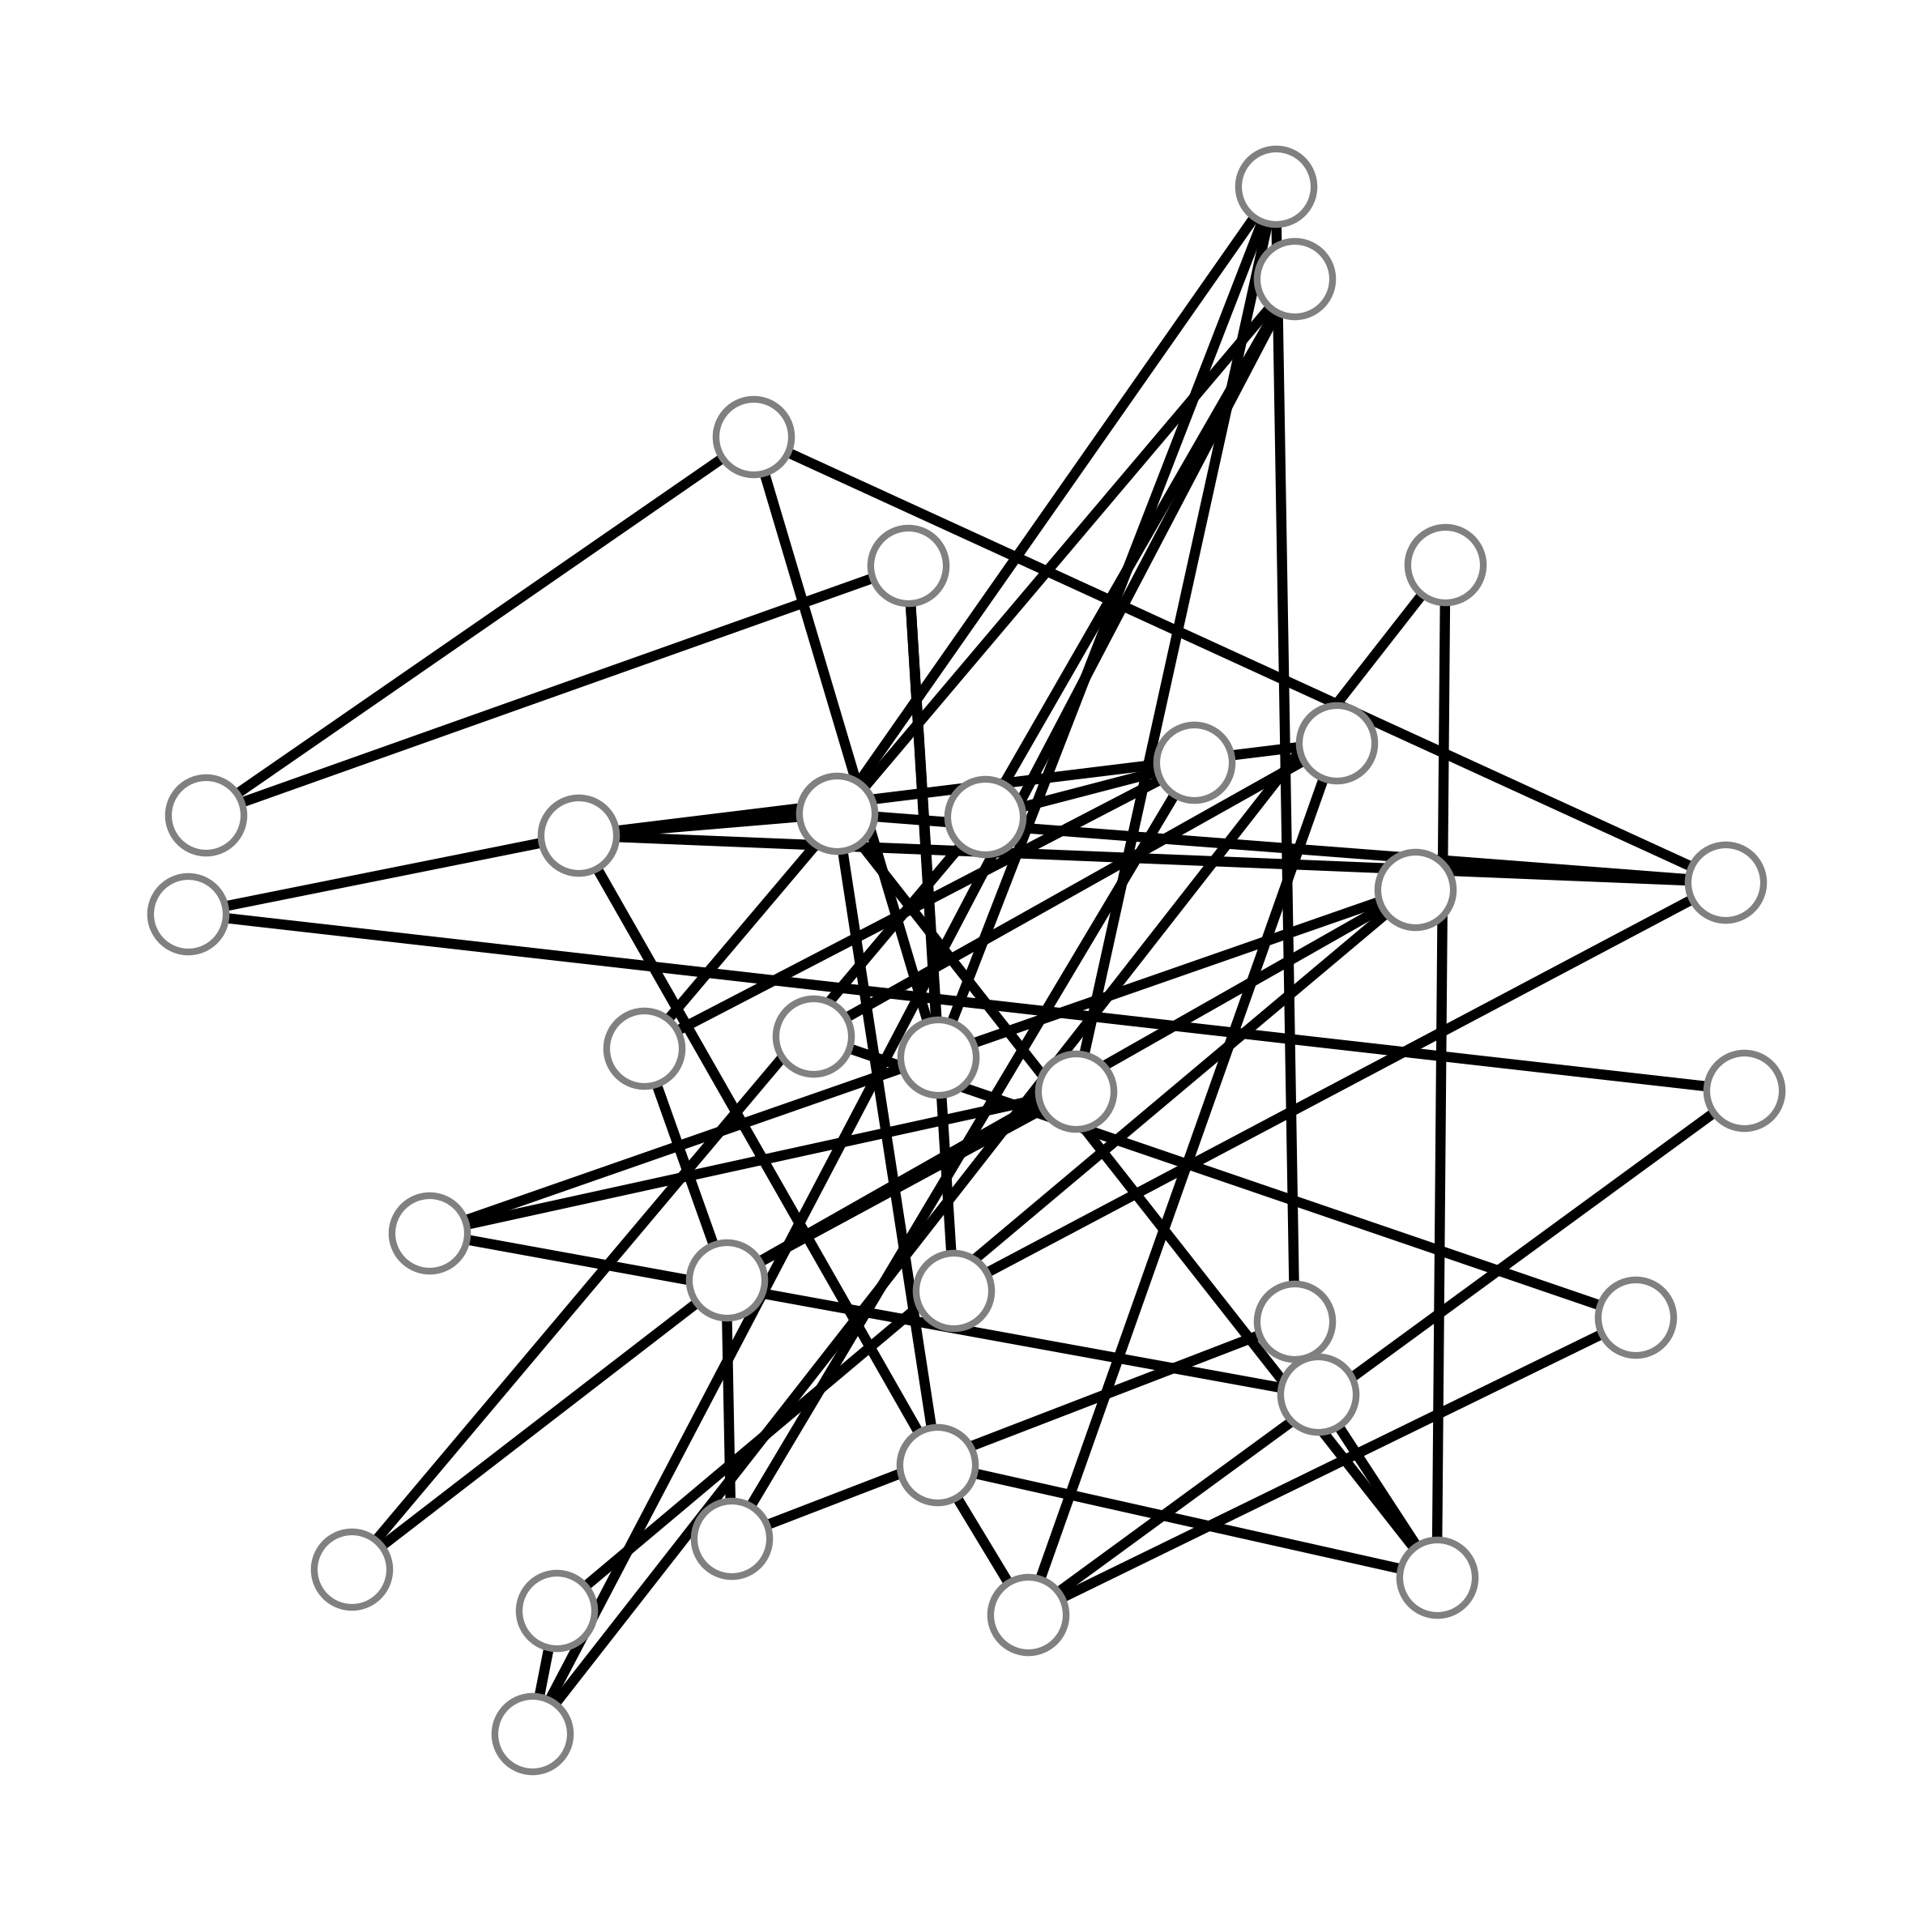

In [18]:
init_random_seed(seed=53)

n_nodes = 32
batch_size = 1024
state_dim = 1000
epochs = 5000
num_desired_trajectories=400

env = GraphEnv(n_nodes, env='random', env_config={'num_desired_trajectories': num_desired_trajectories, 'batch_size': 128})
env.print_info()

dataset = RandomWalkDataset(env.adj_matrix, 128, num_desired_trajectories)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = Agent(env.size, env.n_actions, state_dim)

# cognitive map before training
t_sne_learning_rate = 1.0
early_exaggeration = 1
perp = n_nodes // 4
run_t_sne(model, env, perp, early_exaggeration, t_sne_learning_rate, label=False, name="")

TRAIN_NETWORK = True
if TRAIN_NETWORK:
    loss_record, loss2_record, loss3_record = train_model(model, env, dataloader, epochs)
    torch.save(model.state_dict(), "./tmp_data/reward_random_graph.ptn")
else:
    model.load_state_dict(torch.load("./tmp_data/reward_random_graph.ptn"))
    model = model.to(device)

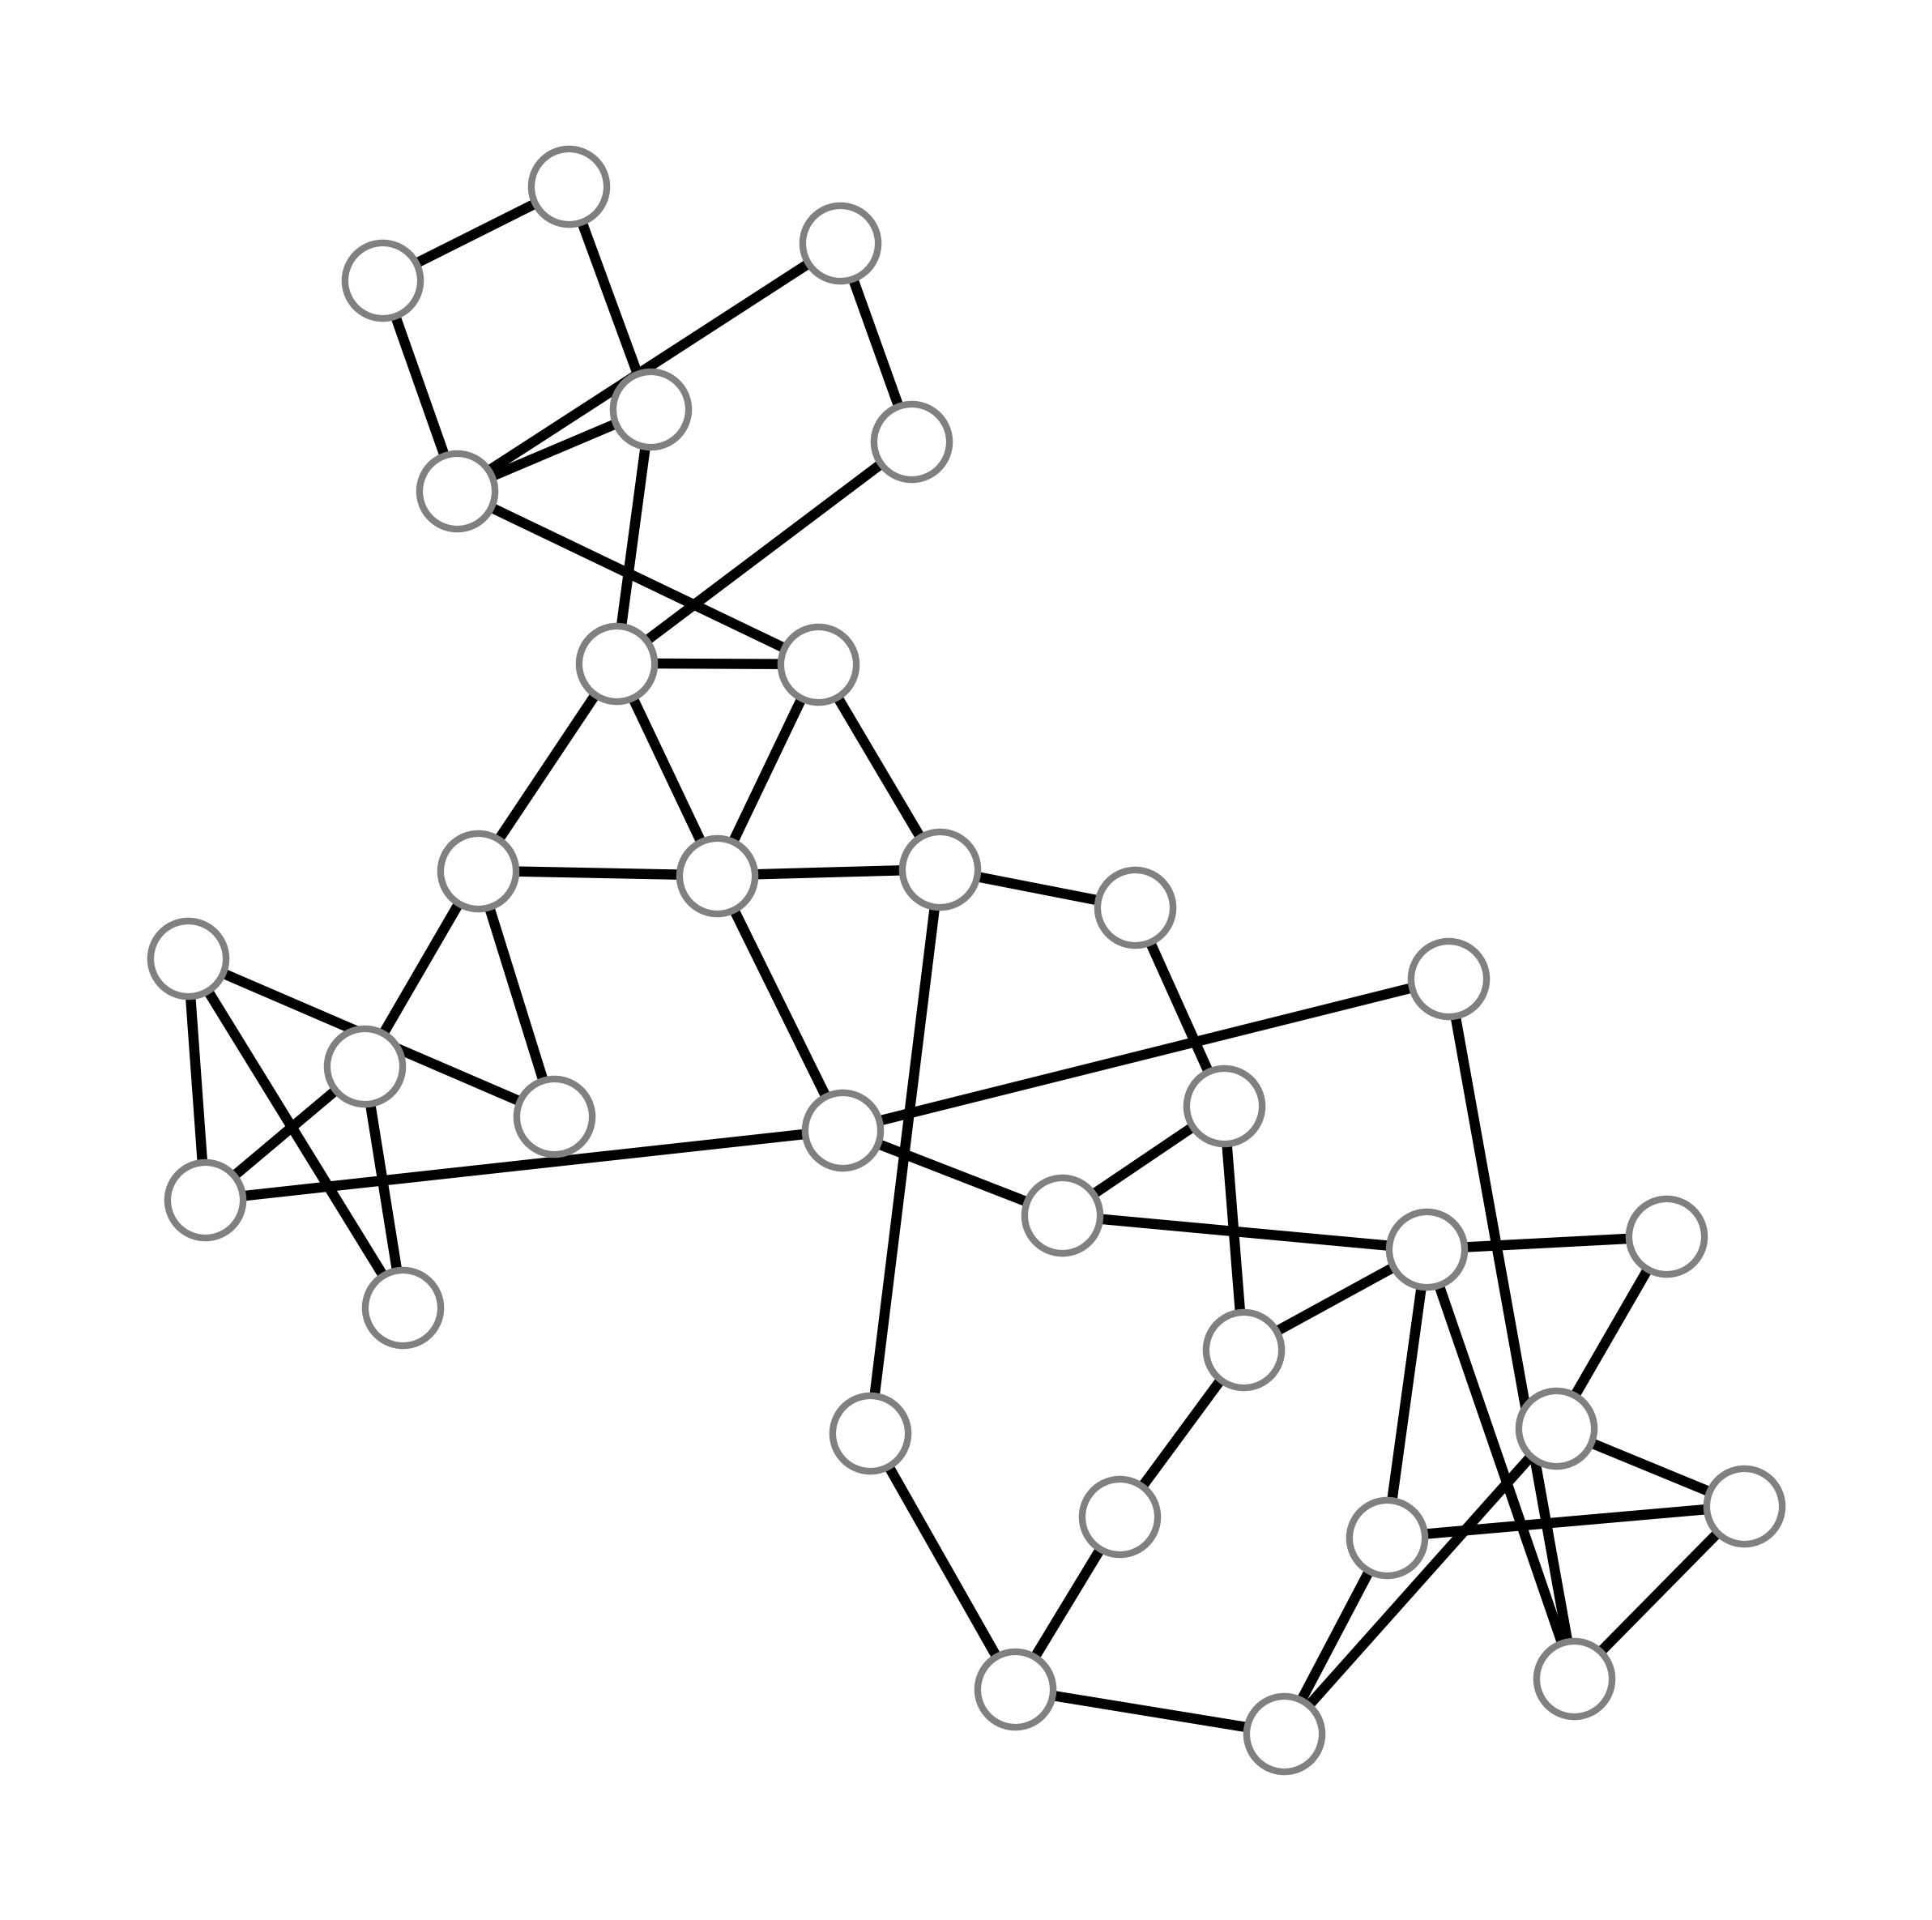

In [ ]:
# draw cognitive map after training
init_random_seed(seed=123456)
t_sne_learning_rate = 200
early_exaggeration = 2.
perp = 20.46
run_t_sne(model, env, perp, early_exaggeration, t_sne_learning_rate, label=False, name="")

Text(0.5, 0, 'Number of G update')

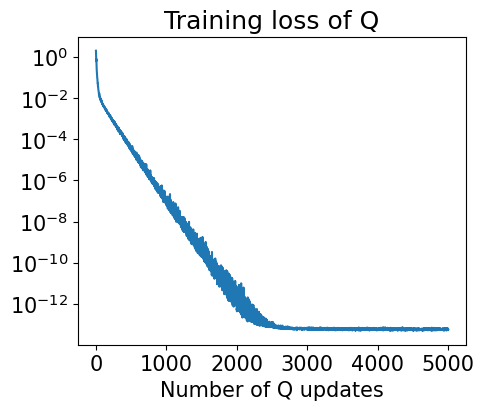

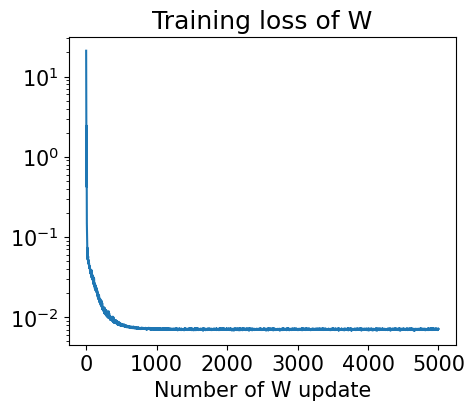

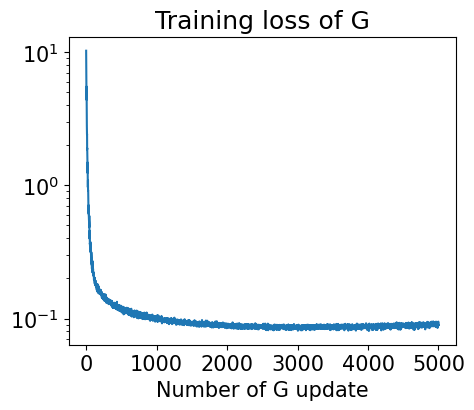

In [20]:
plt.rcParams['font.size'] = 15

plt.figure(dpi=100, figsize=(5, 4))
plt.plot(loss_record)
plt.yscale('log')
plt.title('Training loss of Q')
plt.xlabel('Number of Q updates')

plt.figure(dpi=100, figsize=(5, 4))
plt.plot(loss2_record)
plt.yscale('log')
plt.title('Training loss of W')
plt.xlabel('Number of W update')

plt.figure(dpi=100, figsize=(5, 4))
plt.plot(loss3_record)
plt.yscale('log')
plt.title('Training loss of G')
plt.xlabel('Number of G update')

## Plan process

In [40]:
def move_one_step_traj(model, env, loc, goal, a_record, affordance, action_to_node, next_node_to_action, traj_len_per_theta_cycle, theta_cycle_num, weight=False, print_info=True, with_noise=True, noise_type="GAUSSIAN", noise_param={"sigma":0.2}, log_result=False):
    batch_size = 1

    affordance_vector = torch.zeros(model.a_size, device=device)
    affordance_vector[affordance] = 1
    
    affordance_vector_fix = affordance_vector.clone()
    not_recommended_actions = a_record
    affordance_vector_fix[not_recommended_actions] *= 0.
    
    a_t = torch.zeros((model.a_size, batch_size), dtype=torch.float32, device=device)
    Qo_t = model.Q[:, loc].reshape((-1, 1))
    Qo_star = model.Q[:, goal].reshape((-1, 1))

    u_star = model.W @ Qo_star  # (a_size, 1)
    assert (u_star.shape == (model.a_size, 1))

    traj_rewards = []
    traj_arriveds = []
    traj_actions = []
    traj_nodes = []

    for traj_id in range(theta_cycle_num):
        a_t.zero_()

        actions = []  
        traj_node = [loc]
        arrived = False
        traj_reward = 0
        traj_a_record = copy.deepcopy(a_record)  # traj_a_record is used to guarantee that the current trajectory avoids backtracking
        cur_loc = copy.deepcopy(loc)
        
        for node_id in range(traj_len_per_theta_cycle):
            s_pre = Qo_t + model.V @ a_t
            utility = - model.W @ s_pre + u_star
            g_affordancee = model.G @ s_pre

            # 智能体即将采用的一个当前动作
            assert(utility.shape == (model.a_size, batch_size))
            
            if with_noise:
                if noise_type == "GAUSSIAN":
                    utility += torch.randn_like(utility) * torch.max(utility, dim=0)[0] * noise_param["sigma"]
                else:
                    print("Not support noise type!")

                # gating
                if node_id == 0: 
                    # the real affordance from the environment is directly adopted when t=0
                    utility = utility * affordance_vector_fix.unsqueeze(dim=1)
                else:
                    # the estimated affordance is adopted
                    tmp_aff = g_affordancee
                    tmp_aff[traj_a_record, :] *= 0
                    utility = utility * g_affordancee

                action_idx = torch.argmax(utility).item()
            else:
                utility = utility * g_affordancee
                action_idx = torch.argmax(utility).item()

            actions.append(action_idx)

            traj_a_record.append(action_idx)  # only for affordance calculation in this trajectory, avoid select same action in one trajectory

            a_t[action_idx, :] += 1  

            # 模拟GCML的下游模块估算当前trajectory的reward
            next_loc = action_to_node[action_idx][1].item()
            traj_reward += env.reward[next_loc].item()
            traj_node.append(next_loc)
            cur_loc = copy.deepcopy(next_loc)

            # determine whether the current trajectory has reached the destination
            if torch.norm(s_pre - Qo_star) < 1e-3:
                arrived = True
                traj_reward -= 5 * len(actions)  # the weighted result of path length and reward
                break

        traj_rewards.append(traj_reward)
        traj_arriveds.append(arrived)
        traj_actions.append(actions)
        traj_nodes.append(traj_node)

    if print_info:
        print("trajectory_actions:", traj_actions)
        print("trajectory_arrived:", traj_arriveds)
        print("reward:", traj_rewards)

    min_dis_traj_idx = torch.argmax(torch.tensor(traj_rewards)).item()
    final_action_idx = traj_actions[min_dis_traj_idx][0]

    if log_result:
        save_result = {
            "traj_rewards": traj_rewards,
            "traj_arriveds": traj_arriveds,
            "traj_actions": traj_actions,
            "traj_nodes": traj_nodes,
        }
        return action_to_node[final_action_idx][1].item(), final_action_idx, save_result
    else:
        return action_to_node[final_action_idx][1].item(), final_action_idx


def network_plan_process(model, start, goal, env, traj_len_per_theta_cycle=10, theta_cycle_num=5, weight=False, print_info=False, log_result=False, noise_type="GAUSSIAN", noise_param={"sigma":0.2}):
    a_record = []
    o_record = []
    r_record = []
    loc = int(start)
    length = 0
    
    all_save_result = []

    for i in range(model.o_size):
        r_record.append(env.reward[loc].item())
        o_record.append(loc)
        if loc == goal:
            break
        
        if log_result:
            loc, action, save_result = move_one_step_traj(model, env, loc, goal, a_record, env.affordance[loc], env.action_to_node, env.node_to_action_matrix[loc], traj_len_per_theta_cycle=traj_len_per_theta_cycle, theta_cycle_num=theta_cycle_num, weight=weight, print_info=print_info, log_result=log_result, noise_type=noise_type, noise_param=noise_param)
            all_save_result.append(save_result)
        else:
            loc, action = move_one_step_traj(model, env, loc, goal, a_record, env.affordance[loc], env.action_to_node, env.node_to_action_matrix[loc], traj_len_per_theta_cycle=traj_len_per_theta_cycle, theta_cycle_num=theta_cycle_num, weight=weight, print_info=print_info, log_result=log_result)

        a_record.append(action)
        if weight:
            length += w_connection[o_record[-1], loc]
        if print_info:
            print(f"loc: {loc}, action: {action}")
        
        # If the break statement is commented out, it enables re-planning of the path from the current position to the target at each step within a single planning process.
        break  # plan a single path that is guaranteed to lead from the start to the goal

    if weight:
        if log_result:
            return length, o_record, a_record, all_save_result
        else:    
            return length, o_record, a_record
    else:
        if log_result:
            return i, o_record, a_record, all_save_result, r_record
        else:
            return i, o_record, a_record, r_record

In [ ]:
start_idx = 26 
goal_idx = 1
print("start node:", start_idx, "goal node:", goal_idx)
with torch.no_grad():
    steps, o_record, a_record, step_record, r_record = network_plan_process(model, start_idx, goal_idx, env, traj_len_per_theta_cycle=200, theta_cycle_num=100, log_result=True, noise_type="GAUSSIAN", noise_param={"sigma":0.1})

path_stat = []
for j in range(len(step_record[0]["traj_arriveds"])):
    if step_record[0]["traj_arriveds"][j]:
        path_length = step_record[0]["traj_nodes"][j]  # edge number along trajectory
        path_stat.append(path_length)
for i, p in enumerate(path_stat):
    print("trajectory id:", i, ", trajectory length:", len(p), ", path:", p)

start node: 26 goal node: 1


trajectory id: 0 , trajectory length: 11 , path: [26, 27, 31, 20, 21, 22, 12, 13, 2, 1, 4]
trajectory id: 1 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 2 , trajectory length: 11 , path: [26, 27, 31, 20, 21, 22, 12, 13, 2, 1, 4]
trajectory id: 3 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 4 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 5 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 6 , trajectory length: 12 , path: [26, 27, 24, 23, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 7 , trajectory length: 11 , path: [26, 27, 24, 23, 21, 22, 12, 13, 2, 1, 5]
trajectory id: 8 , trajectory length: 11 , path: [26, 27, 31, 20, 21, 22, 12, 13, 2, 1, 4]
trajectory id: 9 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 29, 9, 10, 4, 5, 1, 25]
trajectory id: 10 , trajectory length: 12 , path: [26, 27, 31, 20, 21, 2